# Power over Ethernet
PoE (Power over Ethernet) is a standard for delivering DC power over twisted-pair ethernet cables. In this notebook we will analyze the efficiency of a specific class of PoE: 802.3at class 4. This standard is also known as PoE+ and can deliver up to 25.5W to a powered device using two twisted pairs.

In [1]:
# This cell can be removed, it is only used for running the notebook during Sphinx documentation build.
import sys, os
if os.getcwd().replace('\\', '/').endswith("/docs/nb"):
    sys.path.insert(0, os.path.abspath(os.path.join("../../src")))

In [2]:
import matplotlib.pyplot as plt
from sysloss.components import *
from sysloss.system import System
import sysloss.diagram as sd

## System definition
PoE delivers power through the mid-tap of the ethernet transformers, as shown in the figure below:
![Poe](PoE.png)

The PSE output voltage is 50-57VDC for PoE+. Dedicated PoE controller chips at both ends negotiate the power level to be delivered. On the Powered Device (PD) side, the circuitry typically consists of a PD controller, a rectifier bridge (voltage polarity on PoE is arbitrary), EMI-filter and an isolated DC/DC converter.

The resistance values of the different parts are set to the following values:
  * Each transformer winding has 0.26ohm resistance.
  * The EMI filter had 0.17 ohm per winding.
  * RJ45 connectors are 20mOhm per contact.
  * Cat5 cable is 0.09ohm/m

The resistance in one conductor path between the PSE and PD is derived as:  
0.5*winding resistance + rj45 + cable + rj45 + 0.5 winding resistance.  
The are two conductors in parallel per pair, cutting resistance in half. But return current has the same resistance, so total resistance is actually the same as for one conductor.

```{tip}
The Rectifier component can model both diode rectifiers and MOSFET rectifiers.
```

Maximum output power for PoE+ is 30W, while delivered power to the PD is up to 25.5W. Let's test these numbers with a diode rectifier on the PD side with 100m Cat5E cable:

In [3]:
diode_vf = {"vi":[48], "io":[.01, .05, .1, .2, .5, 1., 2.], "vdrop":[[.315, .36, .38, .4, .43, .46, .5]]} # diode forward voltage
trans_wr = 0.26 # ethernet transformer resistance, per winding
cable_r = 0.09 # Cat5E cable, resistance per m

poe=System("Power over Ethernet", Source("PSE supply", vo=-55, limits={"po": [0, 30]}), group="PSE")
poe.add_comp("PSE supply", comp=ILoad("PSE controller", ii=11e-3, loss=True), group="PSE")
poe.add_comp("PSE supply", comp=RLoss("Magnetics 1", rs=trans_wr/2), group="PSE")
poe.add_comp("Magnetics 1", comp=RLoss("RJ45 1", rs=0.02), group="PSE")
poe.add_comp("RJ45 1", comp=RLoss("Cat5E cable", rs=100*cable_r))
poe.add_comp("Cat5E cable", comp=RLoss("RJ45 2", rs=0.02), group="PD")
poe.add_comp("RJ45 2", comp=RLoss("Magnetics 2", rs=0.02), group="PD")
poe.add_comp("Magnetics 2", comp=Rectifier("Diode-bridge", vdrop=diode_vf), group="PD")
poe.add_comp("Diode-bridge", comp=RLoss("EMI filter", rs=0.34), group="PD")
poe.add_comp("EMI filter", comp=ILoad("PD controller", ii=.8e-3, loss=True), group="PD")
poe.add_comp("EMI filter", comp=PLoad("PD load", pwr=25.5), group="PD")

,Component,Type,Parent,Group,Vin (V),Vout (V),Iin (A),Iout (A),Power (W),Loss (W),Efficiency (%),Warnings
0,PSE supply,SOURCE,,PSE,-55.0,-55.0,0.5302,0.5302,29.161017,0.0,100.0,
1,Magnetics 1,SLOSS,PSE supply,PSE,-55.0,-54.932504,0.5192,0.5192,28.556021,0.035044,99.87728,
2,RJ45 1,SLOSS,Magnetics 1,PSE,-54.932504,-54.92212,0.5192,0.5192,28.520979,0.005391,99.981097,
3,Cat5E cable,SLOSS,RJ45 1,,-54.92212,-50.249316,0.5192,0.519201,28.51559,2.426124,91.491937,
4,RJ45 2,SLOSS,Cat5E cable,PD,-50.249316,-50.238933,0.519201,0.519201,26.08948,0.005391,99.979335,
5,Magnetics 2,SLOSS,RJ45 2,PD,-50.238933,-50.228549,0.519201,0.519201,26.084089,0.005391,99.979331,
6,Diode-bridge,RECTIFIER,Magnetics 2,PD,-50.228549,49.366246,0.519201,0.519201,26.078698,0.447709,98.283239,
7,EMI filter,SLOSS,Diode-bridge,PD,49.366246,49.189746,0.519201,0.519201,25.63099,0.091654,99.642411,
8,PD load,LOAD,EMI filter,PD,49.189746,0.0,0.518401,0.0,25.5,0.0,100.0,
9,PD controller,LOAD,EMI filter,PD,49.189746,0.0,0.0008,0.0,0.0,0.039352,0.0,


## Analysis

In [9]:
poe.solve()

,Component,Type,Parent,Group,Vin (V),Vout (V),Iin (A),Iout (A),Power (W),Loss (W),Efficiency (%),Warnings
0,PSE supply,SOURCE,,PSE,-50.0,-50.0,0.672342,0.672342,33.617092,0.0,100.0,po
1,Magnetics 1,SLOSS,PSE supply,PSE,-50.0,-49.914026,0.661342,0.661342,33.0671,0.056859,99.828051,
2,RJ45 1,SLOSS,Magnetics 1,PSE,-49.914026,-49.900799,0.661342,0.661342,33.010245,0.008747,99.973501,
3,Cat5E cable,SLOSS,RJ45 1,,-49.900799,-43.948721,0.661342,0.661342,33.001498,3.936364,88.072164,
4,RJ45 2,SLOSS,Cat5E cable,PD,-43.948721,-43.935494,0.661342,0.661342,29.065154,0.008747,99.969904,
5,Magnetics 2,SLOSS,RJ45 2,PD,-43.935494,-43.922268,0.661342,0.661342,29.056408,0.008747,99.969895,
6,Bridge,RECTIFIER,Magnetics 2,PD,-43.922268,43.901154,0.661342,0.659842,29.047661,0.079816,99.725224,
7,EMI filter,SLOSS,Bridge,PD,43.901154,43.676844,0.659842,0.659842,28.967847,0.148033,99.488974,
8,DC/DC,CONVERTER,EMI filter,PD,43.676844,12.0,0.659042,2.083333,28.784897,3.784897,86.851103,
9,User load,LOAD,DC/DC,PD,12.0,0.0,2.083333,0.0,25.0,0.0,100.0,


The result shows that the PSE output power is 29.16W for a 25.5W PD load. Most of the loss is in the cable as expected. Notice also that the output voltage from the Rectifier component is positive with a negative input. 

## Adding an isolated DC/DC converter
The PoE standard requires powered devices to be isolated. So next we add an isolated DC/DC converter to convert to a 12V output. We also add a user load to the 12V - this will be used to calculate the overall system efficiency from the PSE to the 12V output. Furthermore, we will assess the efficiency for the following cases:
  * 10m and 100m Cat5E cable
  * Diode rectifier vs MOSFET rectifier (MOSFET resistance set to 0.016Ohm)

The system is defined in a function, which allows easy parameter changes. The system efficiency is calculated from 1W to 25W in 1W steps.

In [4]:
# efficiency data for the isolated DC/DC converter
dcdc_eff = {"vi":[36, 48, 60], 
            "io":[0.1, 0.4, 0.8, 1, 1.3, 1.5, 2.1], 
            "eff":[[.5, .82, .86, .87, .874, .872, .86], [.55, .84, .867, .88, .882, .88, .873], [.47, .816, .853, .867, .874, .875, .87]]}

def poe_system(length=100, diode_bridge=True, pwr=10):
    poe=System("Power over Ethernet", Source("PSE supply", vo=-50, limits={"po": [0, 30]}), group="PSE")
    poe.add_comp("PSE supply", comp=ILoad("PSE controller", ii=11e-3, loss=True), group="PSE")
    poe.add_comp("PSE supply", comp=RLoss("Magnetics 1", rs=trans_wr/2), group="PSE")
    poe.add_comp("Magnetics 1", comp=RLoss("RJ45 1", rs=0.02), group="PSE")
    poe.add_comp("RJ45 1", comp=RLoss("Cat5E cable", rs=length*cable_r))
    poe.add_comp("Cat5E cable", comp=RLoss("RJ45 2", rs=0.02), group="PD")
    poe.add_comp("RJ45 2", comp=RLoss("Magnetics 2", rs=0.02), group="PD")
    if diode_bridge:
        poe.add_comp("Magnetics 2", comp=Rectifier("Bridge", vdrop=diode_vf), group="PD")
    else:
        poe.add_comp("Magnetics 2", comp=Rectifier("Bridge", rs=0.016, ig=1.5e-3, iq=.7e-3), group="PD")
    poe.add_comp("Bridge", comp=RLoss("EMI filter", rs=0.34), group="PD")
    poe.add_comp("EMI filter", comp=ILoad("PD controller", ii=.8e-3, loss=True), group="PD")
    poe.add_comp("EMI filter", comp=Converter("DC/DC", vo=12, eff=dcdc_eff), group="PD")
    poe.add_comp("DC/DC", comp=PLoad("User load", pwr=pwr), group="PD")
    return poe

When using efficiency curves for voltage converters, it is worthwhile plotting the curve to check the correctness:

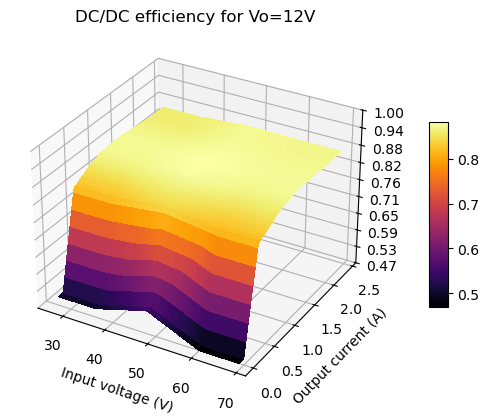

In [5]:
poe=poe_system()
poe.plot_interp("DC/DC", cmap="inferno", inpdata=False, plot3d=True);

Next, let's look at the power-tree of the system:

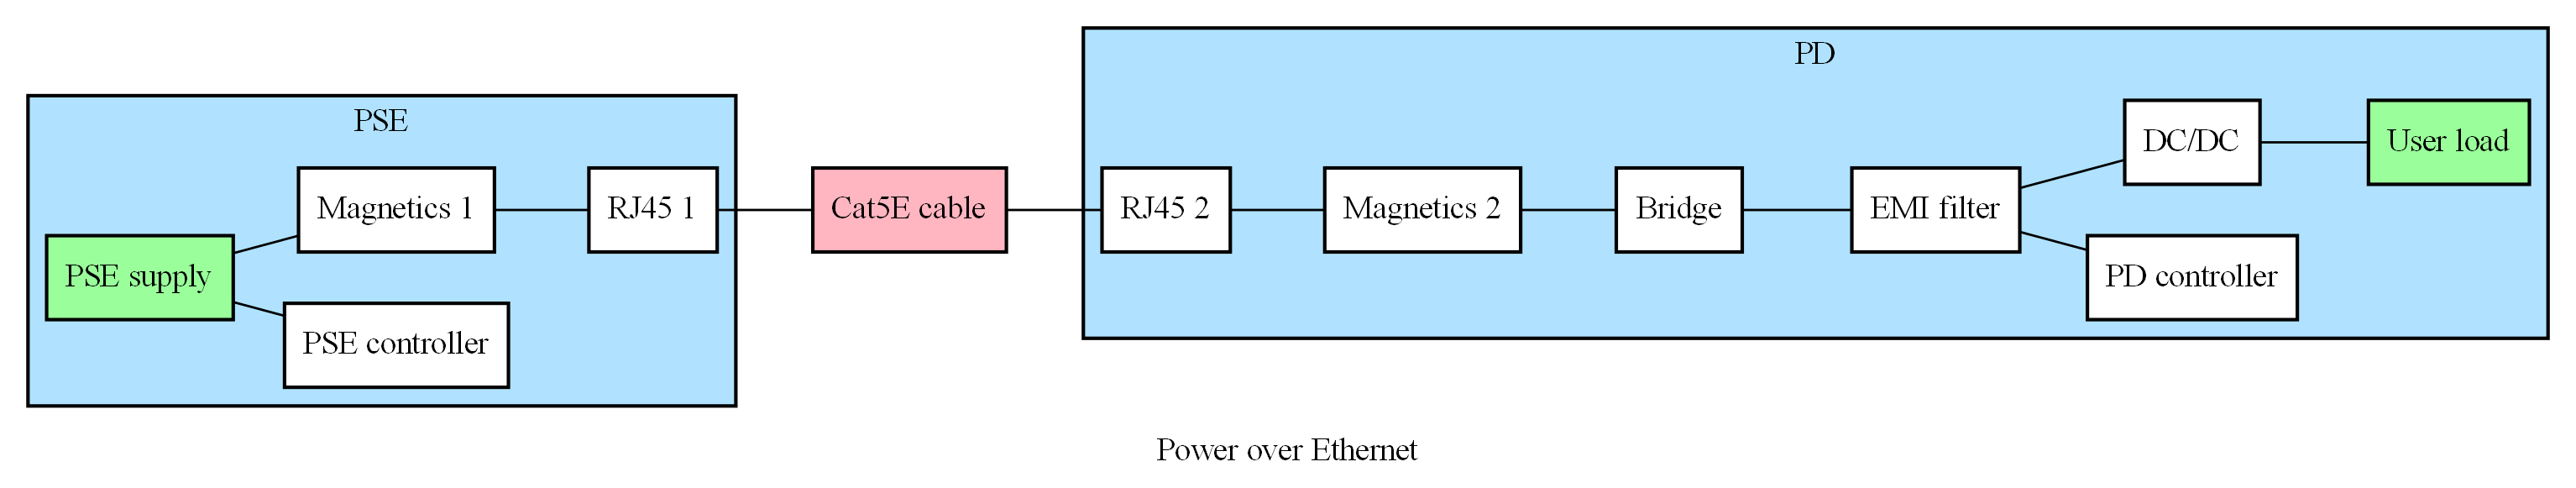

In [6]:
poe_conf = sd.get_conf()
poe_conf["graph"]["rankdir"] = 'LR'
poe_conf["graph"]["dpi"] = '200'
poe_conf["cluster"]["PSE"]= {"fillcolor" :"lightskyblue1"}
poe_conf["cluster"]["PD"]= {"fillcolor" :"lightskyblue1"}
poe_conf["node"]["Cat5E cable"]={"fillcolor" :"lightpink"}
poe_conf["node"]["PSE supply"]={"fillcolor" :"palegreen1"}
poe_conf["node"]["User load"]={"fillcolor" :"palegreen1"}
sd.make_diag(poe, config=poe_conf)

We are going to calculate the system efficiency for power transfer between the PSE supply and the user load (12V), illustrated in green in the power tree above.

## System efficiency
Using the system function defined above, we calculate the efficiency curve for cable lengths of 10m and 100m, combined with either diode or MOSFET rectifier. The resulting curve shows the efficiency for loads that stays below the PSE maximum output power of 30W.

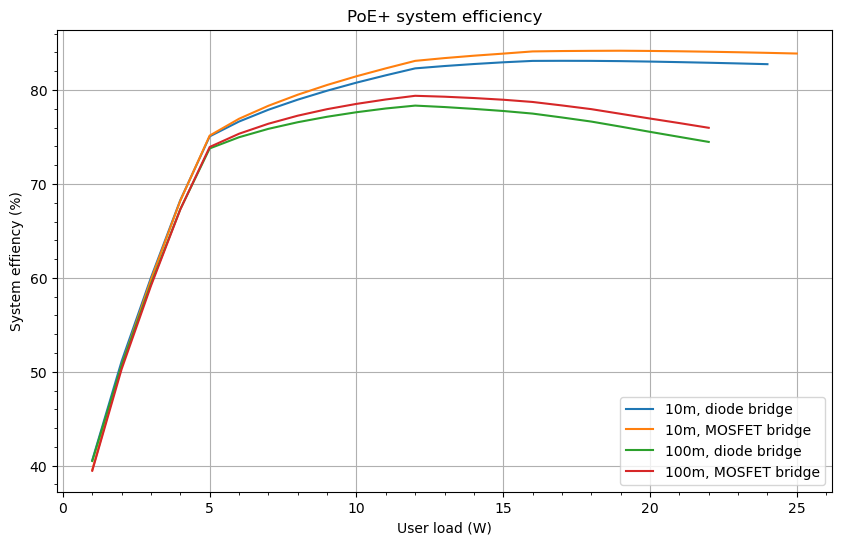

In [7]:
config = [[10, True, "10m, diode bridge"], [10, False, "10m, MOSFET bridge"],
         [100, True, "100m, diode bridge"], [100, False, "100m, MOSFET bridge"]]

plt.figure(figsize=(10,6))
plt.xlabel("User load (W)")
plt.ylabel("System effiency (%)")
plt.grid()
plt.minorticks_on()
for c in config:
    eff = []
    for p in range(1, 26):
        poe=poe_system(length=c[0], diode_bridge=c[1], pwr=p)
        df=poe.solve()
        if df[df.Component == "PSE supply"]["Warnings"].to_list()[0] != "po":
            eff += [df[df.Component == "System total"]["Efficiency (%)"].to_list()[0]]
    plt.plot(range(1,len(eff)+1), eff, label=c[2])
plt.title("PoE+ system efficiency")
plt.legend();

From the curves above we can see that using a MOSFET bridge increases overall efficiency with about 1.5% compared to a diode bridge. Furthermore, 25W at 12V can only be achieved with a 10m cable and MOSFET bridge. With a 100m cable the user load is limited to 22W.

## Summary
This notebook demonstrates how to calculate overall system efficiency for a Power over Ethernet design. The Rectifier component is also put to use to model both diode and MOSFET rectifiers.